In [45]:
# Loading modules
!pip install keras visualkeras tensorflow_hub cufflinks plotly_express graphviz pydot pydotplus wordnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import warnings
import string
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from tensorflow import keras
import gensim.models
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf
from tensorflow.keras import initializers, preprocessing
import tensorflow_hub as hub
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import wordnet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/sentiment'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/sentiment/Twitter_Data.csv
/content/sentiment/model_LSTM.h5
/content/sentiment/tokenizer_LSTM.pkl
/content/sentiment/model.png
/content/sentiment/Reddit_Data.csv


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# Loading data
df_reddit = pd.read_csv('/content/sentiment/Reddit_Data.csv')
df_twitter = pd.read_csv('/content/sentiment/Twitter_Data.csv')

Exploratory Data Analysis (EDA)

# New Section

In [48]:
# Renaming cloumn
df_twitter.rename(columns = {'clean_text':'clean_comment'}, inplace = True)

In [49]:
# Shape of Data
df_twitter.shape,  df_reddit.shape

((162980, 2), (37249, 2))

In [50]:
# Merging Twitter and Reddit Data
df = df_reddit.append(df_twitter).reset_index()

Visualization of Ratio Of Categorical Plots

In [51]:
# Histogram Plot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df['category'].iplot(
    kind='hist',
    xTitle='Categories',
    linecolor='black',
    yTitle='count',
    title='Category Distribution')

In [52]:
# String Length Distribution
pd.DataFrame(df['clean_comment'].str.len())['clean_comment'].iplot(
    kind='hist',
    bins=70,
    xTitle='String length',
    linecolor='black',
    yTitle='count',
    title='String Length Distribution')

In [53]:
# Word Count Distribution
df['word_count'] = df['clean_comment'].str.split().str.len()
df['word_count'].iplot(
    kind='hist',
    bins=70,
    xTitle='String length',
    linecolor='black',
    yTitle='count',
    title='Word Count Distribution')

In [54]:
# Top Word Distribution
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['clean_comment'].dropna().tolist(), 20)
df1 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df1.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words Combined')

In [55]:
# Sample Comment Distribution
import plotly_express as px

fig = px.histogram(df.head(500), x='clean_comment', color='category', histfunc='count')
fig.update_layout(
    title='text (first 500 rows) histogram', 
    xaxis = dict(
        showgrid=True, 
        rangeslider = dict(
            visible=True, 
            thickness=0.05
        )
    ), 
    yaxis = dict(
        showgrid=True
    ), 
    legend = dict(
        orientation='v'
    ), 
    barmode='group', 
    paper_bgcolor='#FFFFFF'
)
fig.show(renderer="iframe")

Target Distribution

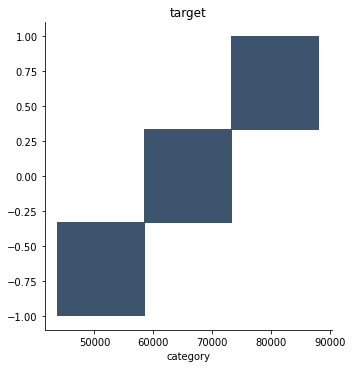

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

locations_vc = df["category"].value_counts()
sns.displot(y=locations_vc.index, x=locations_vc)
plt.title("target")
plt.show()

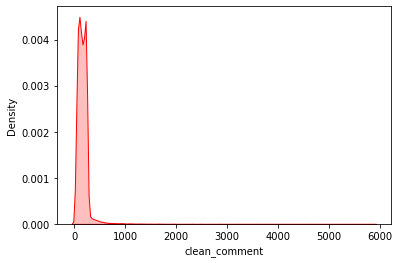

In [57]:
sns.kdeplot(df[df['category'] == -1]['clean_comment'].str.len(), shade=True, color='red')

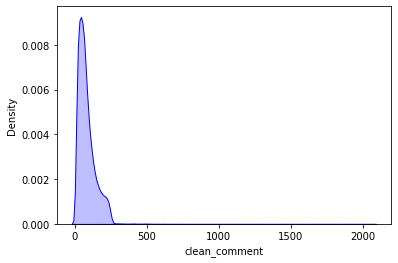

In [58]:
sns.kdeplot(df[df['category'] == 0]['clean_comment'].str.len(), shade=True, color= 'blue')

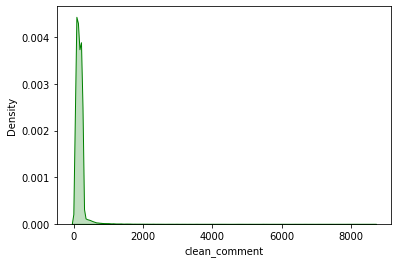

In [59]:
sns.kdeplot(df[df['category'] == 1]['clean_comment'].str.len(), shade=True, color= 'green')

In [60]:
# Target Distribution Heatmaps
import plotly.express as px
# Construct the graph and style it. Further customize your graph by editing this code.
# See Plotly Documentation for help: https://plotly.com/python/plotly-express/
fig = px.density_heatmap(df, x='category')
fig.update_layout(
    title='label density heatmap', 
    xaxis = dict(
        showgrid=True, 
        rangeslider = dict(
            visible=True, 
            thickness=0.05
        )
    ), 
    yaxis = dict(
        showgrid=True
    ), 
    legend = dict(
        orientation='v'
    ), 
    paper_bgcolor='#FFFFFF'
)
fig.show(renderer="iframe")

In [61]:
# Define rename functino
def rename(val):
    if val == -1:
        return "Negative"
    elif val == 0:
        return "Neutral"
    elif val ==1:
        return "Positive"

In [62]:
# Renaming Target Lables
df['category'] = df['category'].apply(rename)
#shuffling the data
df = df.sample(frac=1)

In [63]:
# Data description
df[["clean_comment", "category"]].describe(include='all')

clean_comment  category
count         200125    200222
unique        199715         3
top                   Positive
freq             116     88080

In [64]:
# Checking for Null Value
df.isnull().sum()

index              0
clean_comment    104
category           7
word_count       104
dtype: int64

In [65]:
# Dropping NULL
df = df.dropna()
df.shape

(200118, 4)

In [66]:
# Abberveation Creation
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

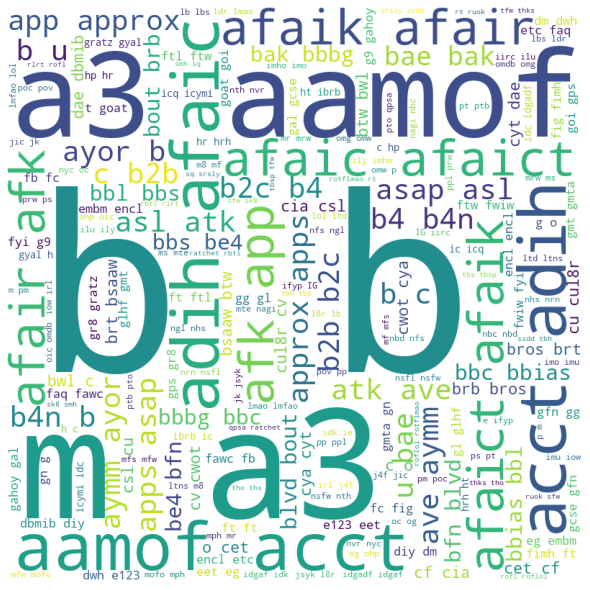

In [67]:
# Generating WordCloud

token = list(abbreviations.keys())
comment_words = ''
stopWords = set(STOPWORDS)


for i in range(len(token)):
    token[i] = token[i].lower()
      
    comment_words += " ".join(token)+" "
    
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopWords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

Filters

In [68]:
# Remove all URLs, replace by URL
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',str(text))


# Remove HTML beacon
def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

# Remove @ and mention, replace by USER
def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)
                     

# Remove numbers, replace it by NUMBER
def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)



# Replace some others smileys with SADFACE
def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)


# Replace some smileys with SMILE
def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    #smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
    return smiley.sub(r'SMILE', text)


# Replace <3 with HEART
def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)


# Factorize elongated words, add ELONG
def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)


# Factorize repeated punctuation, add REPEAT
def remove_repeat_punct(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)



# Remove all punctuations
def remove_all_punct(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)


# Remove punctuations
def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text


# Remove all english stopwords
def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

def stemming(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text


In [69]:
def clean_text(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # Lower text, replace abbreviations
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove  smileys

    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    # Remove repeated puntuations / words
    text = remove_elongated_words(text)
    text = remove_repeat_punct(text)

    text = remove_all_punct(text)
    text = remove_punct(text)
    text = lemmatization(text)
    text = text.lower()

    return text

In [70]:
df["clean_comment"] = df["clean_comment"].apply(clean_text)

In [71]:
# Calculate maximum sequence length
g=[]
for i in df['clean_comment']:
    g.append(i)
    
maxl = max([len(s) for s in g])
print ('Maximum sequence length in the list of sentences:', maxl)

Maximum sequence length in the list of sentences: 8376


In [72]:
# Tokenization
tokenizer = Tokenizer(num_words=50000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['clean_comment'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 116600 unique tokens.


In [73]:
# saving tokenizer
with open('/content/sentiment/tokenizer_LSTM.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [74]:
# Padding
maxl = 1000
X = tokenizer.texts_to_sequences(df['clean_comment'].values)
X = pad_sequences(X, maxlen=maxl)

In [75]:
# Transforming Target Label
Y = pd.get_dummies(df['category'],columns=df["category"]).values
lb = LabelBinarizer().fit(list(set(df['category'].tolist())))

In [76]:
# Building the model achitecture
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.TPUStrategy(tpu)

with tpu_strategy.scope():
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(120000,200,input_length=maxl))
    model.add(tf.keras.layers.SpatialDropout1D(0.4))
    model.add(tf.keras.layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 200)         24000000  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1000, 200)        0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 24,321,403
Trainable params: 24,321,403
Non-trainable params: 0
_________________________________________________________________


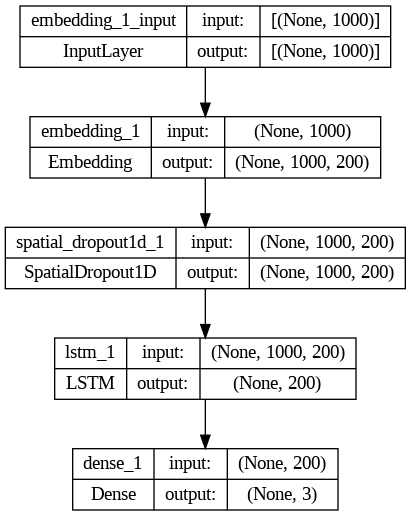

In [78]:
# Model Visualization
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [79]:
# Spliting the date into train and test sets
from sklearn.model_selection import train_test_split
train_x, test_x , train_y, test_y = train_test_split(X, Y, test_size=.3)

In [80]:
# run model 
from tensorflow.keras.callbacks import EarlyStopping
history = model.fit(train_x, train_y, epochs=5, batch_size=10*tpu_strategy.num_replicas_in_sync, validation_split=0.15, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
1489/1489 [==============================] - 580s 382ms/step - loss: 0.3918 - accuracy: 0.8553 - val_loss: 0.2550 - val_accuracy: 0.9103
Epoch 2/5
1489/1489 [==============================] - 562s 377ms/step - loss: 0.2010 - accuracy: 0.9290 - val_loss: 0.2056 - val_accuracy: 0.9275
Epoch 3/5
1489/1489 [==============================] - 562s 378ms/step - loss: 0.1502 - accuracy: 0.9464 - val_loss: 0.2146 - val_accuracy: 0.9225
Epoch 4/5
1489/1489 [==============================] - 562s 377ms/step - loss: 0.1182 - accuracy: 0.9580 - val_loss: 0.2287 - val_accuracy: 0.9221
Epoch 5/5
1489/1489 [==============================] - 562s 378ms/step - loss: 0.0935 - accuracy: 0.9677 - val_loss: 0.2489 - val_accuracy: 0.9190


In [89]:
# save model
model.save('/content/sentiment/model_LSTM.h5')

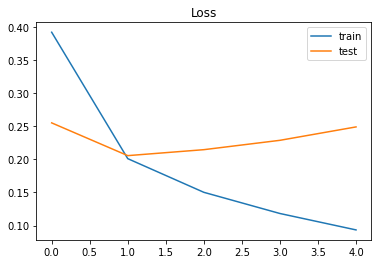

In [82]:
# Training Accuracy
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

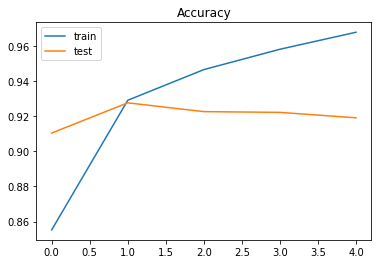

In [83]:
# Validation Accuracy
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

1877/1877 [==============================] - 77s 41ms/step


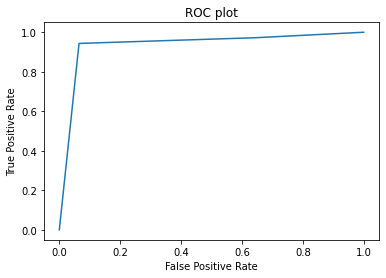

In [84]:
# ROC Curve
fpr, tpr, _ = roc_curve(test_y.argmax(axis=1),model.predict(test_x).argmax(axis=1), pos_label=2)
plt.plot(fpr,tpr)
plt.title("ROC plot")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1877/1877 [==============================] - 76s 40ms/step


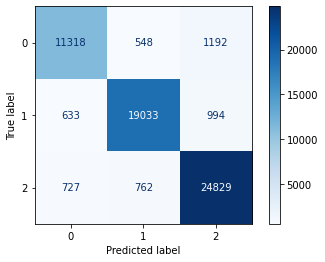

In [85]:
# Confusion Matrix
cm_rm_2 = confusion_matrix((test_y).argmax(axis=1),model.predict(test_x).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rm_2)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [86]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(test_y.argmax(axis=1),model.predict(test_x).argmax(axis=1)))

1877/1877 [==============================] - 76s 40ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     13058
           1       0.94      0.92      0.93     20660
           2       0.92      0.94      0.93     26318

    accuracy                           0.92     60036
   macro avg       0.92      0.91      0.91     60036
weighted avg       0.92      0.92      0.92     60036

